In [109]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft

## Funções Auxiliares

In [110]:
def remove_periodic(X, df_index, detrending=True, frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    
    return rad - rad_clean_ts.values, rad_clean_ts.values

In [111]:
def normalized_cross_correlation(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    dv = math.sqrt(np.var(x) * np.var(y))
    
    corr = 0

    if dv != 0:
        for xx,yy in zip(x,y):
            corr = corr + (((xx - mx) * (yy - my)) / dv)
    
    return corr/len(x)

In [112]:
def daily_normalized_correlation(df1, df2):
    corr = 0

    ind  = pd.DataFrame({"dayofyear": df1.index.dayofyear, "year": df1.index.year})

    for index, row in ind.iterrows():
        #print("Day:", row["dayofyear"], ", Year:", row["year"])
        station_a = df1[(df1.index.dayofyear == row["dayofyear"]) & (df1.index.year == row["year"])].irradiance.tolist()
        station_b = df2[(df2.index.dayofyear == row["dayofyear"]) & (df2.index.year == row["year"])].irradiance.tolist()
        v = np.var(station_a)
        corr = corr + normalized_cross_correlation(station_a, station_b)
    result = corr / len(ind)

    print("Normalized Correlation:", result)
    return result

In [113]:
def daily_weighted_correlation(df1, df2):
    corr = 0
    var = 0
    
    ind  = pd.DataFrame({"dayofyear": df1.index.dayofyear, "year": df1.index.year})

    for index, row in ind.iterrows():
        #print("Day:", row["dayofyear"], ", Year:", row["year"])
        station_a = df1[(df1.index.dayofyear == row["dayofyear"]) & (df1.index.year == row["year"])].irradiance.tolist()
        station_b = df2[(df2.index.dayofyear == row["dayofyear"]) & (df2.index.year == row["year"])].irradiance.tolist()
        v = np.var(station_a)
        #corr = corr + (np.correlate(station_a, station_b)[0] * v)
        corr = corr + (normalized_cross_correlation(station_a, station_b)* v)
        var = var + v
    result = corr / var   

    print("Weighted Correlation:", result)
    return result

In [114]:
def normalize(x, a, b):
    norm_x = []
    minx = min(x)
    maxx = max(x)
    for xx in x:
        res = ((b - a) * ((xx - minx) / (maxx - minx))) + a
        norm_x.append(res)
    
    return norm_x

In [115]:
def pearson_correlation_coef(x1, x2, nlags):

    lags = np.arange(0,nlags)
    pearson = []
    std = np.std(x1) * np.std(x2)

    for lag in lags:
        cv = np.cov(x1[lag:], x2[0:(len(x2)-lag)])
        pearson.append(cv[0,1] / std)
    
    return pearson

# Analise de Dados

## Base SONDA

In [116]:
## Mac
os.chdir("/Users/cseveriano/spatio-temporal-forecasting/")

## Windows
#os.chdir("C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting")
#sys.path.append('C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting\\src\\ext-libraries\\pyFTS')

################################

fln_df = pd.read_csv('data/processed/SONDA/FLN-15min.csv', sep=";", parse_dates=['date'], index_col='date')
fln_df = fln_df[(fln_df.index >= '2013-11-01') & (fln_df.index <= '2015-11-01')]
fln_df = fln_df.fillna(method='ffill')

joi_df = pd.read_csv('data/processed/SONDA/JOI-15min.csv', sep=";", parse_dates=['date'], index_col='date')
joi_df = joi_df[(joi_df.index >= '2013-11-01') & (joi_df.index <= '2015-11-01')]
joi_df = joi_df.fillna(method='ffill')

sbr_df = pd.read_csv('data/processed/SONDA/SBR-15min.csv', sep=";", parse_dates=['date'], index_col='date')
sbr_df = sbr_df[(sbr_df.index >= '2013-11-01') & (sbr_df.index <= '2015-11-01')]
sbr_df = sbr_df.fillna(method='ffill')

In [117]:
fln_df = fln_df.resample('H').mean()
joi_df = joi_df.resample('H').mean()
sbr_df = sbr_df.resample('H').mean()

In [118]:
fln_df = fln_df[(fln_df.index.hour >= 7) & (fln_df.index.hour <= 22)]
joi_df = joi_df[(joi_df.index.hour >= 7) & (joi_df.index.hour <= 22)]
sbr_df = sbr_df[(sbr_df.index.hour >= 7) & (sbr_df.index.hour <= 22)]

In [119]:
fln_residual, fln_clean = remove_periodic(fln_df['glo_avg'],fln_df.index)
joi_residual, joi_clean = remove_periodic(joi_df['glo_avg'],joi_df.index)
sbr_residual, sbr_clean = remove_periodic(sbr_df['glo_avg'],sbr_df.index)

In [120]:
fln_ratio = [x/y for x, y in zip(fln_df['glo_avg'].tolist(), fln_clean)]
joi_ratio = [x/y for x, y in zip(joi_df['glo_avg'].tolist(), joi_clean)]
sbr_ratio = [x/y for x, y in zip(sbr_df['glo_avg'].tolist(), sbr_clean)]

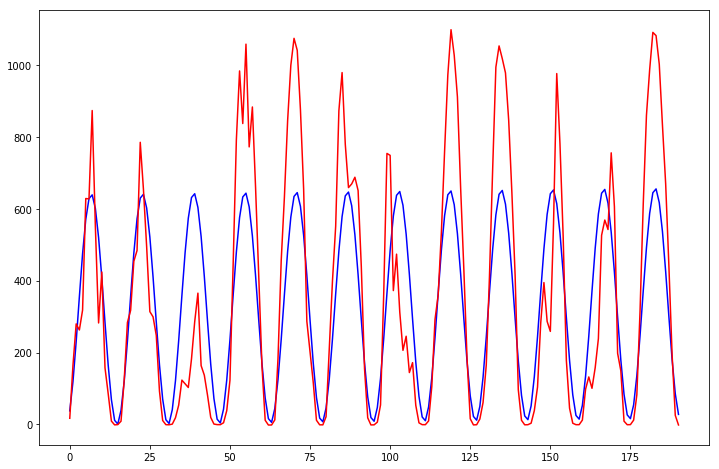

In [121]:
fig = plt.figure(figsize=(12, 8))
plt.plot(fln_clean[1:192], color='blue')
plt.plot(fln_df[1:192].glo_avg.tolist(), color='red')
plt.show()

In [122]:
fln_df = pd.DataFrame(data={'glo_avg': fln_df.glo_avg.tolist(), 'residual': fln_residual, 'clean': fln_clean, 'ratio': fln_ratio, 'date' : fln_df.index}, index=fln_df.index)
joi_df = pd.DataFrame(data={'glo_avg': joi_df.glo_avg.tolist(), 'residual': joi_residual, 'clean': joi_clean, 'ratio': joi_ratio, 'date' : joi_df.index}, index=joi_df.index)
sbr_df = pd.DataFrame(data={'glo_avg': sbr_df.glo_avg.tolist(), 'residual': sbr_residual, 'clean': sbr_clean, 'ratio': sbr_ratio, 'date' : sbr_df.index}, index=sbr_df.index)

In [123]:
df1 = pd.DataFrame(data={'irradiance': fln_df.residual.tolist(), 'date' : fln_df.index}, index=fln_df.index)
df2 = pd.DataFrame(data={'irradiance': joi_df.residual.tolist(), 'date' : joi_df.index}, index=joi_df.index)


In [ ]:
daily_normalized_correlation(df1, df2)

In [ ]:
daily_weighted_correlation(df1, df2)

In [128]:
pearson_correlation_coef(fln_df.residual.tolist(),fln_df.residual.tolist(), 48)

[1.0000856237691587,
 0.82748085648079495,
 0.63461765262508829,
 0.45671396079713239,
 0.31171316830653434,
 0.19280148333831826,
 0.10025342056097282,
 0.038328361970728669,
 0.0082145866572527447,
 0.011227786969350529,
 0.038966377312898474,
 0.081064509259687764,
 0.1380163111299568,
 0.20017681361357675,
 0.26409447180889711,
 0.31861515510414251,
 0.33295041927950247,
 0.29014628636928447,
 0.21805869984658408,
 0.14439715259587046,
 0.08271660070823042,
 0.040344188238362978,
 0.012043163028915282,
 -0.013574608068049774,
 -0.028872764599550304,
 -0.028034401629343498,
 -0.01382589848578889,
 0.0083770319540301553,
 0.035765998429156655,
 0.069959894874301917,
 0.10978390285908274,
 0.15130137397459281,
 0.17019526362160628,
 0.14886200528551041,
 0.10312519760886994,
 0.058588167150392716,
 0.027648842555405711,
 0.0045270996212118707,
 -0.015414976999290113,
 -0.031116643848574706,
 -0.040344005374398882,
 -0.041484248052714834,
 -0.034745000736014504,
 -0.024221431779846099,

## Base SINGA

In [ ]:
import glob

In [ ]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="Tm",parse_dates=['Tm'], header=0, sep="\t")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    return frame

In [ ]:
#Mac
#singa_path = '/Users/cseveriano/spatio-temporal-forecasting/data/raw/SINGA-Nobre/716 2017-11/''

#Windows
singa_path = 'C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting\\data\\raw\\SINGA-Nobre\\'

s716_df = load_data(singa_path+"716", '15min')
s716_df = s716_df.fillna(method='ffill')

s717_df = load_data(singa_path+"717", '15min')
s717_df = s717_df.fillna(method='ffill')

In [ ]:
s716_df.head()

In [ ]:
s716_df = s716_df[(s716_df.index.hour >= 7) & (s716_df.index.hour <= 18)]
s717_df = s717_df[(s717_df.index.hour >= 7) & (s717_df.index.hour <= 18)]


In [ ]:
s716_residual, s716_clean = remove_periodic(s716_df['AvgGsi00'],s716_df.index, frequency_threshold=0.01e11)
s717_residual, s717_clean = remove_periodic(s717_df['AvgGsi00'],s717_df.index, frequency_threshold=0.01e11)

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(s716_clean[1:192], color='blue')
plt.plot(s716_df[1:192].AvgGsi00.tolist(), color='red')
plt.show()

In [ ]:
s716_df = pd.DataFrame(data={'AvgGsi00': s716_df.AvgGsi00.tolist(), 'residual': s716_residual, 'clean': s716_clean, 'date' : s716_df.index}, index=s716_df.index)
s717_df = pd.DataFrame(data={'AvgGsi00': s717_df.AvgGsi00.tolist(), 'residual': s717_residual, 'clean': s717_clean, 'date' : s717_df.index}, index=s717_df.index)


In [ ]:
df1 = pd.DataFrame(data={'irradiance': s716_df.residual.tolist(), 'date' : s716_df.index}, index=s716_df.index)
df2 = pd.DataFrame(data={'irradiance': s717_df.residual.tolist(), 'date' : s717_df.index}, index=s717_df.index)

In [ ]:
daily_normalized_correlation(df1, df2)